# EHMT1: Kleefstra Syndrome

**Kleefstra Syndrome (OMIM #610253)**, a rare developmental disorder caused by pathogenic variants in the *EHMT1* gene, is characterized by a range of symptoms including severe mental retardation, hypotonia, brachy(micro)cephaly, epileptic seizures, flat face with hypertelorism, synophrys, anteverted nares, everted lower lip, carp mouth with macroglossia, and heart defects. 

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.7.1


# EHMT1
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for EHMT1.

In [2]:
gene_symbol = 'EHMT1'
mane_tx_id = 'NM_024757.5'
mane_protein_id = 'NP_079033.4'

In [4]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.21") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

validation.summarize()

Individuals Processed:   2%|▏         | 3/125 [00:00<00:38,  3.18individuals/s]

Expected a result but got an Error for variant: 9_137710964_137710964_C_--107177bp--
<html><head><title>Error</title></head><body><h2>Request too large</h2></body></html>


Individuals Processed:  23%|██▎       | 29/125 [00:06<00:26,  3.59individuals/s]

Expected a result but got an Error for variant: 9_137762821_137775108_--12288bp--_--528bp--
{"error":"Allele must be A,T,G,C or SO term [got: NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN]"}


Individuals Processed: 100%|██████████| 125/125 [00:50<00:00,  2.49individuals/s]
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #10
   errors:
   ·Individual PMID_39013458_individual_VUSM110048 has no genotype data (variants) to work with. Add variants or remove the individual from the analysis
    variants
      #0
       warnings:
       ·Individual PMID_39013458_individual_VUSM110048 has an error with variant 9_137710964_137710964_C_--107177bp--. Try again or remove variant from testing... Expected a result but got an Error. See log for details.
  patient #23
   errors:
   ·Individual PMID_39013458_individual_KS13004 has no genotype data (variants) to work with. Add variants or remove the individual from the analysis
    variants
      #0
       warnings:
       ·Individual PMID_39013458_individual_KS13004 has an error with variant SO:1000044_HGNC:24650_EHMT1. Try again or remove variant from testing... Unsupported variant class VariantClass.TR

In [5]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo=hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Global developmental delay,HP:0001263,114
Intellectual disability,HP:0001249,112
Chronic constipation,HP:0012450,59
Autism,HP:0000717,55
Recurrent infections,HP:0002719,52
Hypotonia,HP:0001252,49
Hypermetropia,HP:0000540,41
Overweight,HP:0025502,39
Developmental regression,HP:0002376,35
Hearing impairment,HP:0000365,35


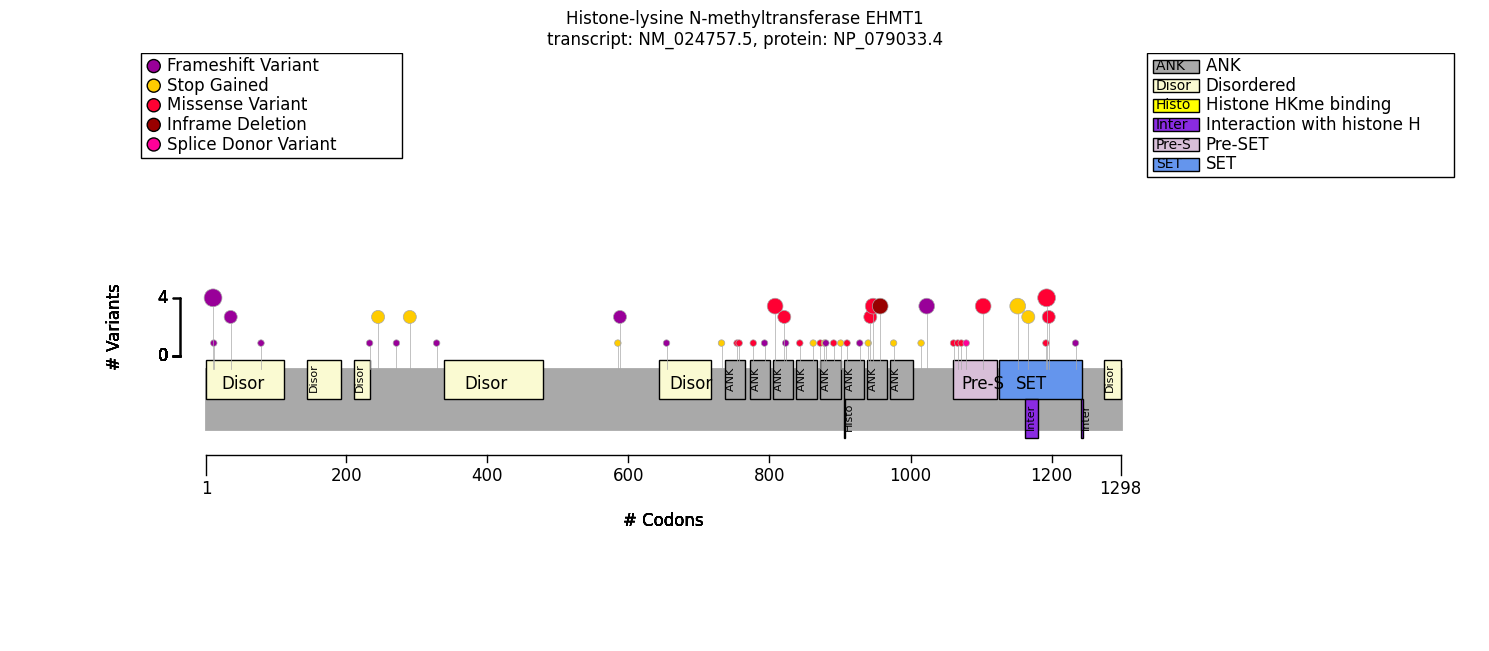

In [7]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

ehmt1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
ehmt1_fig.tight_layout()

In [14]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort)

Name,Type,Coordinates,Count,Variants
Disordered,REGION,1 - 111,8,p.Arg12ThrfsTer25; p.Glu14GlyfsTer23; p.Glu14SerfsTer8; p.Gly37ValfsTer17; p.Gln82ArgfsTer7
Disordered,REGION,144 - 192,0,
Disordered,REGION,211 - 234,1,p.Glu236ArgfsTer47
Disordered,REGION,339 - 479,0,
Disordered,REGION,644 - 717,1,p.Gln657AlafsTer41
ANK 1,REPEAT,737 - 766,2,p.Leu755Arg; p.Leu758Pro
ANK 2,REPEAT,772 - 801,2,p.His778Pro; p.Gln794ArgfsTer17
ANK 3,REPEAT,805 - 834,6,p.Val822Gly; p.Ile826SerfsTer53; p.Pro809Leu
ANK 4,REPEAT,838 - 868,2,p.His844Tyr; p.Gln863Ter
ANK 5,REPEAT,872 - 901,4,p.Glu882ValfsTer16; p.Leu892Arg; p.Trp879Ter; p.Gly873Val


In [15]:
from gpsea.view import CohortVariantViewer
cvv = CohortVariantViewer(tx_id=mane_tx_id)
cvv.process(cohort)

Variant key,Variant (cDNA),Variant (protein),Overlapping Exons,Effects,Count
SO:1000029_HGNC:24650_EHMT1,SV involving EHMT1,p.?,,chromosomal deletion,40
9_137811590_137811590_C_T,c.2842C>T,p.Arg948Trp,19,missense,3
9_137790891_137790891_C_T,c.2426C>T,p.Pro809Leu,16,missense,3
9_137813421_137813423_CCT_C,c.3072_3073del,p.Val1026GlnfsTer150,21,frameshift,3
9_137813009_137813015_CTTTCTT_C,c.2873_2878del,p.Phe958_Leu959del,20,inframe deletion,3
9_137815998_137815998_G_A,c.3310G>A,p.Glu1104Lys,23,missense,3
9_137716649_137716649_G_AT,c.109_110insT,p.Gly37ValfsTer17,3,frameshift,2
9_137811578_137811578_C_T,c.2830C>T,p.His944Tyr,19,missense,2
9_137743418_137743418_C_T,c.871C>T,p.Arg291Ter,5,stop gained,2
9_137834389_137834389_A_T,c.3581A>T,p.Asn1194Ile,26,missense,2


# Genotype-Phenotype Correlation (GPC) Analysis

In [9]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [ ]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, mane_tx_id)
missense_predicate = monoallelic_predicate(
    a_predicate=missense,
    b_predicate=~missense,
    a_label='Missense', 
    b_label='Other'
)


missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=missense_predicate,
    pheno_predicates=pheno_predicates,
)

from gpsea.view import MtcStatsViewer
mtc_viewer = MtcStatsViewer()
mtc_viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,45
HMF08,Skipping general term,52
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,104


In [11]:
from gpsea.view import summarize_hpo_analysis
summarize_hpo_analysis(hpo, missense_result)

Allele group                                Missense          \
                                               Count Percent   
Recurrent infections [HP:0002719]               9/12     75%   
Hearing impairment [HP:0000365]                 4/23     17%   
Chronic constipation [HP:0012450]               9/26     35%   
Autism [HP:0000717]                             9/22     41%   
Intellectual disability [HP:0001249]           24/28     86%   
Overweight [HP:0025502]                        10/23     43%   
Global developmental delay [HP:0001263]        27/28     96%   
Increased body weight [HP:0004324]             15/15    100%   
Neurodevelopmental abnormality [HP:0012759]    27/27    100%   
Neurodevelopmental delay [HP:0012758]          27/27    100%   
Atypical behavior [HP:0000708]                 15/15    100%   
Autistic behavior [HP:0000729]                   9/9    100%   
Abdominal symptom [HP:0011458]                 13/13    100%   
Unusual infection [HP:0032101]                   9/9    100%   
Constipation [HP:0002019]                        9/9    100%   

Allele group                                Rest of the cohort          \
                                                         Count Percent   
Recurrent infections [HP:0002719]                        48/49     98%   
Hearing impairment [HP:0000365]                          31/71     44%   
Chronic constipation [HP:0012450]                        50/90     56%   
Autism [HP:0000717]                                      44/79     56%   
Intellectual disability [HP:0001249]                     87/94     93%   
Overweight [HP:0025502]                                  28/83     34%   
Global developmental delay [HP:0001263]                  86/93     92%   
Increased body weight [HP:0004324]                       44/44    100%   
Neurodevelopmental abnormality [HP:0012759]              91/91    100%   
Neurodevelopmental delay [HP:0012758]                    86/86    100%   
Atypical behavior [HP:0000708]                           66/66    100%   
Autistic behavior [HP:0000729]                           44/44    100%   
Abdominal symptom [HP:0011458]                           66/66    100%   
Unusual infection [HP:0032101]                           48/48    100%   
Constipation [HP:0002019]                                50/50    100%   

Allele group                                                              
                                            Corrected p values  p values  
Recurrent infections [HP:0002719]                     0.201447  0.021606  
Hearing impairment [HP:0000365]                       0.201447  0.026860  
Chronic constipation [HP:0012450]                     0.379105  0.075821  
Autism [HP:0000717]                                   0.819614  0.237889  
Intellectual disability [HP:0001249]                  0.819614  0.273205  
Overweight [HP:0025502]                               1.000000  0.463158  
Global developmental delay [HP:0001263]               1.000000  0.679768  
Increased body weight [HP:0004324]                    1.000000  1.000000  
Neurodevelopmental abnormality [HP:0012759]           1.000000  1.000000  
Neurodevelopmental delay [HP:0012758]                 1.000000  1.000000  
Atypical behavior [HP:0000708]                        1.000000  1.000000  
Autistic behavior [HP:0000729]                        1.000000  1.000000  
Abdominal symptom [HP:0011458]                        1.000000  1.000000  
Unusual infection [HP:0032101]                        1.000000  1.000000  
Constipation [HP:0002019]                             1.000000  1.000000

Lets also try to investigate a possible sex difference, since this has been previously mentioned in Kleefstra. 

In [13]:
from gpsea.analysis.predicate.genotype import sex_predicate
mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=sex_predicate(),
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo, mf_result)

Sex                                         FEMALE           MALE          \
                                             Count Percent  Count Percent   
Hearing impairment [HP:0000365]              19/62     31%  16/35     46%   
Chronic constipation [HP:0012450]            42/79     53%  17/40     42%   
Hypotonia [HP:0001252]                       33/81     41%  16/44     36%   
Intellectual disability [HP:0001249]         73/81     90%  39/44     89%   
Autism [HP:0000717]                          39/72     54%  16/32     50%   
Increased body weight [HP:0004324]           41/41    100%  20/20    100%   
Neurodevelopmental abnormality [HP:0012759]  77/77    100%  42/42    100%   
Global developmental delay [HP:0001263]      73/80     91%  41/44     93%   
Neurodevelopmental delay [HP:0012758]        73/73    100%  41/41    100%   
Recurrent maladaptive behavior [HP:5200241]  40/40    100%  11/11    100%   
Atypical behavior [HP:0000708]               61/61    100%  23/23    100%   
Autistic behavior [HP:0000729]               39/39    100%  16/16    100%   
Abdominal symptom [HP:0011458]               53/53    100%  26/26    100%   
Recurrent infections [HP:0002719]            34/36     94%  24/26     92%   
Unusual infection [HP:0032101]               34/34    100%  24/24    100%   
Constipation [HP:0002019]                    42/42    100%  17/17    100%   

Sex                                                                       
                                            Corrected p values  p values  
Hearing impairment [HP:0000365]                            1.0  0.186638  
Chronic constipation [HP:0012450]                          1.0  0.332985  
Hypotonia [HP:0001252]                                     1.0  0.703179  
Intellectual disability [HP:0001249]                       1.0  0.768708  
Autism [HP:0000717]                                        1.0  0.831770  
Increased body weight [HP:0004324]                         1.0  1.000000  
Neurodevelopmental abnormality [HP:0012759]                1.0  1.000000  
Global developmental delay [HP:0001263]                    1.0  1.000000  
Neurodevelopmental delay [HP:0012758]                      1.0  1.000000  
Recurrent maladaptive behavior [HP:5200241]                1.0  1.000000  
Atypical behavior [HP:0000708]                             1.0  1.000000  
Autistic behavior [HP:0000729]                             1.0  1.000000  
Abdominal symptom [HP:0011458]                             1.0  1.000000  
Recurrent infections [HP:0002719]                          1.0  1.000000  
Unusual infection [HP:0032101]                             1.0  1.000000  
Constipation [HP:0002019]                                  1.0  1.000000

In [ ]:
exon1 = VariantPredicates.exon(exon=1, tx_id=mane_tx_id)
exon2 = VariantPredicates.exon(exon=2, tx_id=mane_tx_id)
exon3 = VariantPredicates.exon(exon=3, tx_id=mane_tx_id)
frameshift = VariantPredicates.variant_effect(effect=VariantEffect.FRAMESHIFT_VARIANT, tx_id=mane_tx_id)

n_term = exon1 | exon2 | exon3
n_term_fs = n_term & frameshift

n_term_fs_pred = monoallelic_predicate(
    a_predicate=n_term_fs,
    b_predicate=~n_term_fs,
    a_label="N Term Frameshift",
    b_label="other"
)
n_term_fs_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=n_term_fs_pred,
    pheno_predicates=pheno_predicates,
)
mtc_viewer.process(n_term_fs_result)
#

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,47
HMF05,Skipping term because one genotype had zero observations,13
HMF08,Skipping general term,52
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,104


In [18]:
summarize_hpo_analysis(hpo, n_term_fs_result)

Empty DataFrame
Columns: [(N Term Frameshift, Count), (N Term Frameshift, Percent), (other, Count), (other, Percent), (, p values)]
Index: []

In [19]:
ablation = VariantPredicates.variant_effect(effect=VariantEffect.TRANSCRIPT_ABLATION, tx_id=mane_tx_id)



ablation_pred = monoallelic_predicate(
    a_predicate=ablation,
    b_predicate=~ablation,
    a_label="CNV",
    b_label="other"
)
ablation_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=ablation_pred,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo, ablation_result)

Allele group                                   CNV          other          \
                                             Count Percent  Count Percent   
Microcephaly [HP:0000252]                    15/26     58%  10/73     14%   
Chronic constipation [HP:0012450]            27/39     69%  32/77     42%   
Intellectual disability [HP:0001249]         39/40     98%  72/82     88%   
Hearing impairment [HP:0000365]              13/29     45%  22/65     34%   
Hypotonia [HP:0001252]                       17/40     42%  30/82     37%   
Increased body weight [HP:0004324]           14/14    100%  45/45    100%   
Neurodevelopmental abnormality [HP:0012759]  40/40    100%  78/78    100%   
Global developmental delay [HP:0001263]      38/40     95%  75/81     93%   
Neurodevelopmental delay [HP:0012758]        38/38    100%  75/75    100%   
Atypical behavior [HP:0000708]               26/26    100%  55/55    100%   
Autism [HP:0000717]                          18/34     53%  35/67     52%   
Autistic behavior [HP:0000729]               18/18    100%  35/35    100%   
Abdominal symptom [HP:0011458]               30/30    100%  49/49    100%   
Recurrent infections [HP:0002719]            22/23     96%  35/38     92%   
Unusual infection [HP:0032101]               22/22    100%  35/35    100%   
Constipation [HP:0002019]                    27/27    100%  32/32    100%   

Allele group                                                              
                                            Corrected p values  p values  
Microcephaly [HP:0000252]                             0.000472  0.000029  
Chronic constipation [HP:0012450]                     0.047967  0.005996  
Intellectual disability [HP:0001249]                  0.531986  0.099747  
Hearing impairment [HP:0000365]                       1.000000  0.359158  
Hypotonia [HP:0001252]                                1.000000  0.556848  
Increased body weight [HP:0004324]                    1.000000  1.000000  
Neurodevelopmental abnormality [HP:0012759]           1.000000  1.000000  
Global developmental delay [HP:0001263]               1.000000  1.000000  
Neurodevelopmental delay [HP:0012758]                 1.000000  1.000000  
Atypical behavior [HP:0000708]                        1.000000  1.000000  
Autism [HP:0000717]                                   1.000000  1.000000  
Autistic behavior [HP:0000729]                        1.000000  1.000000  
Abdominal symptom [HP:0011458]                        1.000000  1.000000  
Recurrent infections [HP:0002719]                     1.000000  1.000000  
Unusual infection [HP:0032101]                        1.000000  1.000000  
Constipation [HP:0002019]                             1.000000  1.000000

# 
The eight individuals with a PAV in the ANKR domain had a higher IQ (mean IQ 65 vs. 54, p = 0.03). Furthermore, feeding difficulties were significantly less prevalent (3/20 vs. 20/47, p = 0.03), as well as structural heart defects (2/20 vs. 15/47, p = 0.06), and recurrent infections had a lower prevalence (6/20 vs. 27/47, p = 0.04). Similarly, the five individuals with a PAV in the SET domain also had a higher IQ (mean IQ 66 vs. 54, p = 0.04) and lower prevalence of recurrent infections (3/13 vs. 27/47, p = 0.03) (Figure S6).

In [20]:
## ankyrin repeat (ANKR) domain
ank1 = VariantPredicates.protein_feature(feature_id="ANK 1", protein_metadata=protein_meta) #737 - 766	
ank2 = VariantPredicates.protein_feature(feature_id="ANK 2", protein_metadata=protein_meta) #772 - 801
ank3 = VariantPredicates.protein_feature(feature_id="ANK 3", protein_metadata=protein_meta) #805 - 834
ank4 = VariantPredicates.protein_feature(feature_id="ANK 4", protein_metadata=protein_meta) #838 - 868
ank5 = VariantPredicates.protein_feature(feature_id="ANK 5", protein_metadata=protein_meta) #872 - 901
ank6 = VariantPredicates.protein_feature(feature_id="ANK 6", protein_metadata=protein_meta) #905 - 934	

ank_repeat = ank1|ank2|ank3|ank4|ank5|ank6

ank_repeat_predicate = monoallelic_predicate(
    a_predicate=ank_repeat,
    b_predicate=~ank_repeat,
    a_label="ANKR",
    b_label="other"
)

ank_repeat_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=ank_repeat_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo, ank_repeat_result)

Allele group                                  ANKR            other          \
                                             Count Percent    Count Percent   
Recurrent infections [HP:0002719]            11/13     85%    46/48     96%   
Intellectual disability [HP:0001249]         15/18     83%   96/104     92%   
Hypotonia [HP:0001252]                        5/18     28%   42/104     40%   
Chronic constipation [HP:0012450]             7/17     41%    52/99     53%   
Hearing impairment [HP:0000365]               6/13     46%    29/81     36%   
Overweight [HP:0025502]                       6/15     40%    32/91     35%   
Autism [HP:0000717]                           9/16     56%    44/85     52%   
Increased body weight [HP:0004324]             8/8    100%    51/51    100%   
Neurodevelopmental abnormality [HP:0012759]  17/17    100%  101/101    100%   
Global developmental delay [HP:0001263]      17/18     94%   96/103     93%   
Neurodevelopmental delay [HP:0012758]        17/17    100%    96/96    100%   
Atypical behavior [HP:0000708]               13/13    100%    68/68    100%   
Autistic behavior [HP:0000729]                 9/9    100%    44/44    100%   
Abdominal symptom [HP:0011458]               12/12    100%    67/67    100%   
Unusual infection [HP:0032101]               11/11    100%    46/46    100%   
Constipation [HP:0002019]                      7/7    100%    52/52    100%   

Allele group                                                              
                                            Corrected p values  p values  
Recurrent infections [HP:0002719]                          1.0  0.196275  
Intellectual disability [HP:0001249]                       1.0  0.206694  
Hypotonia [HP:0001252]                                     1.0  0.432949  
Chronic constipation [HP:0012450]                          1.0  0.439196  
Hearing impairment [HP:0000365]                            1.0  0.542592  
Overweight [HP:0025502]                                    1.0  0.774907  
Autism [HP:0000717]                                        1.0  0.790862  
Increased body weight [HP:0004324]                         1.0  1.000000  
Neurodevelopmental abnormality [HP:0012759]                1.0  1.000000  
Global developmental delay [HP:0001263]                    1.0  1.000000  
Neurodevelopmental delay [HP:0012758]                      1.0  1.000000  
Atypical behavior [HP:0000708]                             1.0  1.000000  
Autistic behavior [HP:0000729]                             1.0  1.000000  
Abdominal symptom [HP:0011458]                             1.0  1.000000  
Unusual infection [HP:0032101]                             1.0  1.000000  
Constipation [HP:0002019]                                  1.0  1.000000

In [21]:
set_domain = VariantPredicates.protein_feature(feature_id="SET", protein_metadata=protein_meta)

set_predicate = monoallelic_predicate(
    a_predicate=set_domain,
    b_predicate=~set_domain,
    a_label="SET",
    b_label="other"
)

set_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=set_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo, set_result)

Allele group                                   SET            other          \
                                             Count Percent    Count Percent   
Chronic constipation [HP:0012450]             5/13     38%   54/103     52%   
Autism [HP:0000717]                            3/8     38%    50/93     54%   
Overweight [HP:0025502]                       5/11     45%    33/95     35%   
Global developmental delay [HP:0001263]      13/13    100%  100/108     93%   
Intellectual disability [HP:0001249]         13/13    100%   98/109     90%   
Increased body weight [HP:0004324]             6/6    100%    53/53    100%   
Neurodevelopmental abnormality [HP:0012759]  13/13    100%  105/105    100%   
Neurodevelopmental delay [HP:0012758]        13/13    100%  100/100    100%   
Atypical behavior [HP:0000708]                 7/7    100%    74/74    100%   
Autistic behavior [HP:0000729]                 3/3    100%    50/50    100%   
Abdominal symptom [HP:0011458]                 7/7    100%    72/72    100%   
Recurrent infections [HP:0002719]              7/7    100%    50/54     93%   
Unusual infection [HP:0032101]                 7/7    100%    50/50    100%   
Constipation [HP:0002019]                      5/5    100%    54/54    100%   

Allele group                                                              
                                            Corrected p values  p values  
Chronic constipation [HP:0012450]                          1.0  0.389778  
Autism [HP:0000717]                                        1.0  0.472467  
Overweight [HP:0025502]                                    1.0  0.518269  
Global developmental delay [HP:0001263]                    1.0  0.597130  
Intellectual disability [HP:0001249]                       1.0  0.605035  
Increased body weight [HP:0004324]                         1.0  1.000000  
Neurodevelopmental abnormality [HP:0012759]                1.0  1.000000  
Neurodevelopmental delay [HP:0012758]                      1.0  1.000000  
Atypical behavior [HP:0000708]                             1.0  1.000000  
Autistic behavior [HP:0000729]                             1.0  1.000000  
Abdominal symptom [HP:0011458]                             1.0  1.000000  
Recurrent infections [HP:0002719]                          1.0  1.000000  
Unusual infection [HP:0032101]                             1.0  1.000000  
Constipation [HP:0002019]                                  1.0  1.000000